In [3]:
import torch
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth, output_dim):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [4]:
import sys
sys.path.append('../../utils/')

In [5]:
from Bias_Variance_Estimator import estimate_bias_variance_mse

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim

In [8]:
import torchvision
from torchvision import datasets,transforms

In [9]:
def get_mnist_data(num_train_samples, train=True):
    """Loads and preprocesses the MNIST dataset for the experiment."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # flatten to vector
    ])
    dataset = torchvision.datasets.MNIST(root='./data', train=train,
                                           download=True, transform=transform)

    if train and num_train_samples is not None:
        indices = torch.randperm(len(dataset))[:num_train_samples]
        dataset = torch.utils.data.Subset(dataset, indices)
    # print(dataset.targets)
    return dataset

In [10]:
train_dataset = get_mnist_data(num_train_samples=20000)
test_dataset = get_mnist_data(num_train_samples=None, train=False)

X_train_list, y_train_list = [], []
for data, target in train_dataset:
  X_train_list.append(data.numpy())
  y_train_list.append(target)
X_train_np = np.array(X_train_list).reshape(len(X_train_list), -1)
y_train_np = np.eye(10)[np.array(y_train_list)]

X_test_np = test_dataset.data.float().numpy() / 255.0
y_test_np = np.eye(10)[test_dataset.targets.numpy()]

In [11]:
X_train_np.shape,y_train_np.shape

((20000, 784), (20000, 10))

In [12]:
y_train_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [13]:
y_test_np.shape

(10000, 10)

In [14]:
X_test_np.shape

(10000, 28, 28)

In [15]:
NUM_BOOTSTRAP_MODELS = 20
MAX_EPOCHS = 300
PATIENCE = 300
LEARNING_RATE = 0.001

hidden_unit_sizes =[8,32,64,128,256,512,1024,2048]

In [16]:
results = []
for hidden_units in hidden_unit_sizes:
    print(f"---Training with {hidden_units} hidden units----")
    bias_sq, variance, total_error,error_sum,avg_train_loss,test_loss= estimate_bias_variance_mse( model_class=MLPRegressor,
      X_train=X_train_np,
      y_train=y_train_np,
      X_test=X_test_np,
      y_test=y_test_np,
      loss_fn=nn.MSELoss(),
      model_kwargs={'input_dim':28*28,'hidden_dim':hidden_units,'depth':1,'output_dim':10},
      num_models=NUM_BOOTSTRAP_MODELS,
      max_epochs=MAX_EPOCHS,
      patience=PATIENCE,
      lr=LEARNING_RATE,
      batch_size=128)
    results.append({
        'hidden_units': hidden_units,
        'bias': bias_sq,
        'variance': variance,
        'total_error': total_error,
        'error_sum': error_sum,
        'avg_train_loss':avg_train_loss,
        'test_loss':test_loss
    })

---Training with 8 hidden units----
Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training Model 2/20 ---

--- Training Model 3/20 ---

--- Training Model 4/20 ---

--- Training Model 5/20 ---

--- Training Model 6/20 ---

--- Training Model 7/20 ---

--- Training Model 8/20 ---

--- Training Model 9/20 ---

--- Training Model 10/20 ---

--- Training Model 11/20 ---

--- Training Model 12/20 ---

--- Training Model 13/20 ---

--- Training Model 14/20 ---

--- Training Model 15/20 ---

--- Training Model 16/20 ---

--- Training Model 17/20 ---

--- Training Model 18/20 ---

--- Training Model 19/20 ---

--- Training Model 20/20 ---

--- Final Results ---
Bias²:    0.0830
Variance: 0.0119
Total error: 0.0949
Bias² + Variance: 0.0949
---Training with 32 hidden units----
Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training Model 2/20 ---

--- Training Model 3/20 ---

--- Training Model 4/20 ---

--- Training Model 5/20 ---

--- Training

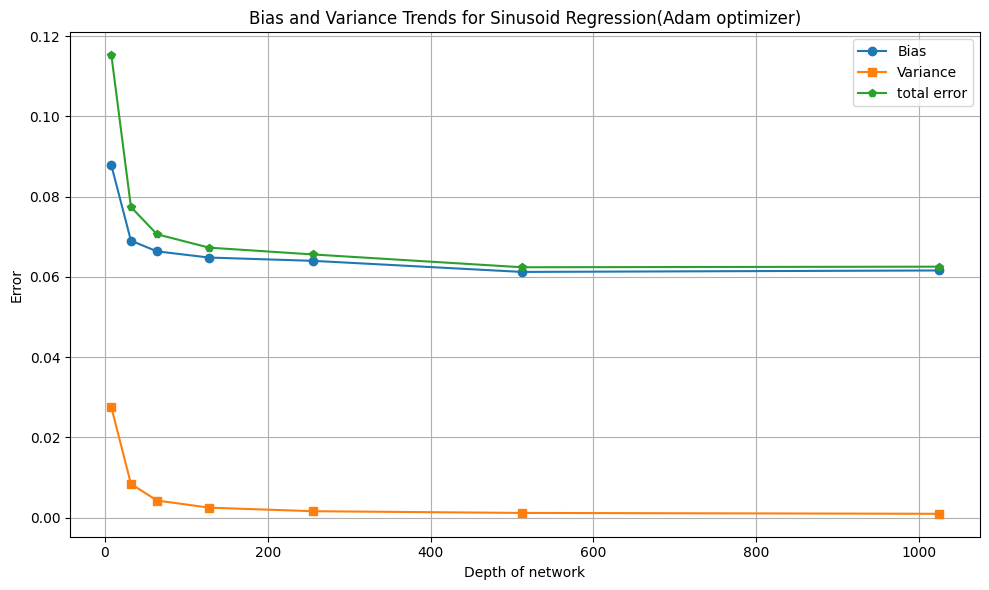

In [26]:
hidden_unit_sizes =[8,32,64,128,256,512,1024]
bias_values = [res['bias'] for res in results]
variance_values = [res['variance'] for res in results]
error_values = [res['total_error'] for res in results]
bias_plus_variance = [res['error_sum'] for res in results]
    
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, bias_values, marker='o', label='Bias')
plt.plot(hidden_unit_sizes, variance_values, marker='s', label='Variance')
plt.plot(hidden_unit_sizes, error_values, marker='p', label='total error')
# plt.plot(hidden_unit_sizes, bias_plus_variance, marker='p', label='bias + variance')

    
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(Adam optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
avg_test_loss = [res['avg_train_loss'] for res in results]
avg_test_loss = [res['avg_test_loss'] for res in results]
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, avg_test_loss, marker='o', label='Bias')
# plt.plot(hidden_unit_sizes, avg_test_loss, marker='s', label='Variance')

    
plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(Adam optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [17]:
results

[{'hidden_units': 8,
  'bias': np.float64(0.08858629709922194),
  'variance': np.float32(0.023726368),
  'total_error': np.float64(0.1123126627652355),
  'error_sum': np.float64(0.11231266542219043)},
 {'hidden_units': 16,
  'bias': np.float64(0.08330279159339918),
  'variance': np.float32(0.016876427),
  'total_error': np.float64(0.10017921128711449),
  'error_sum': np.float64(0.10017921905013574)},
 {'hidden_units': 64,
  'bias': np.float64(0.06857158526003775),
  'variance': np.float32(0.0038844289),
  'total_error': np.float64(0.07245601529780527),
  'error_sum': np.float64(0.07245601413928386)},
 {'hidden_units': 128,
  'bias': np.float64(0.06812604128622239),
  'variance': np.float32(0.0021640218),
  'total_error': np.float64(0.07029006323997278),
  'error_sum': np.float64(0.07029006311909085)},
 {'hidden_units': 256,
  'bias': np.float64(0.06439688764023743),
  'variance': np.float32(0.0013683503),
  'total_error': np.float64(0.06576523788905676),
  'error_sum': np.float64(0.065

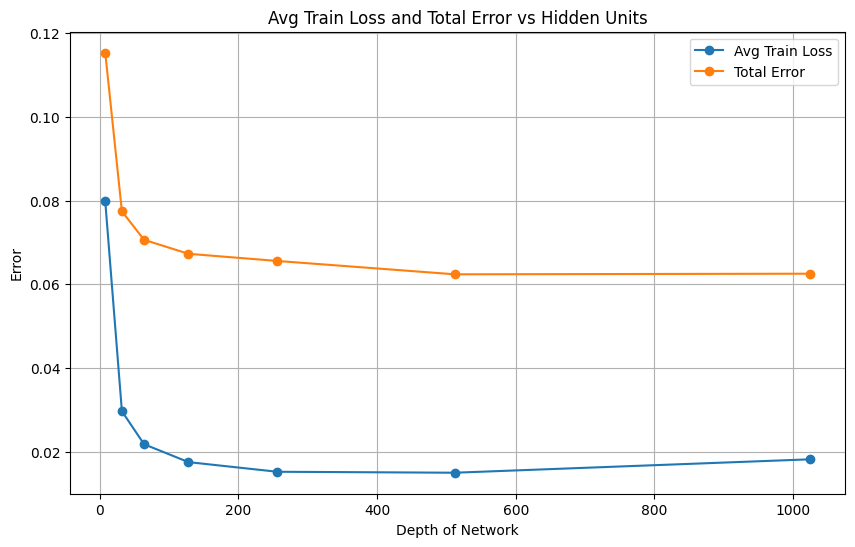

In [25]:
total_error = [r['total_error'] for r in results]
avg_train_loss = [r['avg_train_loss'] for r in results]
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
# plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Depth of Network')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs Hidden Units')
plt.legend()
plt.grid(True)
plt.show()

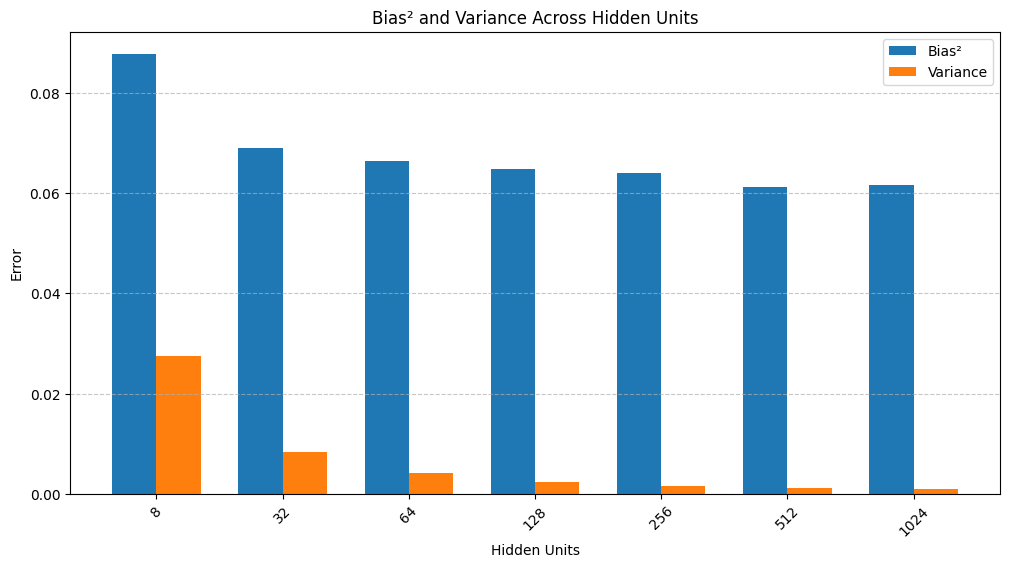

In [27]:
bias_sq = [r['bias'] for r in results]
variance = [r['variance'] for r in results]


x = np.arange(len(hidden_unit_sizes))  
width = 0.35  
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bias_sq, width, label='Bias²')
plt.bar(x + width/2, variance, width, label='Variance')


plt.xticks(x, hidden_unit_sizes, rotation=45)
plt.xlabel('Hidden Units')
plt.ylabel('Error')
plt.title('Bias² and Variance Across Hidden Units')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
bias_sq, variance, total_error,error_sum,avg_train_loss= estimate_bias_variance_mse( model_class=MLPRegressor,
      X_train=X_train_np,
      y_train=y_train_np,
      X_test=X_test_np,
      y_test=y_test_np,
      loss_fn=nn.MSELoss(),
      model_kwargs={'input_dim':28*28,'hidden_dim':2048,'depth':1,'output_dim':10},
      num_models=NUM_BOOTSTRAP_MODELS,
      max_epochs=MAX_EPOCHS,
      patience=PATIENCE,
      lr=LEARNING_RATE,
      batch_size=128)
results.append({
        'hidden_units': hidden_units,
        'bias': bias_sq,
        'variance': variance,
        'total_error': total_error,
        'error_sum': error_sum,
        'avg_train_loss':avg_train_loss
    })

Starting experiment with 20 models...

--- Training Model 1/20 ---

--- Training Model 2/20 ---

--- Training Model 3/20 ---

--- Training Model 4/20 ---

--- Training Model 5/20 ---

--- Training Model 6/20 ---

--- Training Model 7/20 ---

--- Training Model 8/20 ---

--- Training Model 9/20 ---

--- Training Model 10/20 ---

--- Training Model 11/20 ---

--- Training Model 12/20 ---

--- Training Model 13/20 ---

--- Training Model 14/20 ---

--- Training Model 15/20 ---

--- Training Model 16/20 ---

--- Training Model 17/20 ---

--- Training Model 18/20 ---

--- Training Model 19/20 ---

--- Training Model 20/20 ---

--- Final Results ---
Bias:    0.0625
Variance: 0.0008
Total error: 0.0633
Bias² + Variance: 0.0633


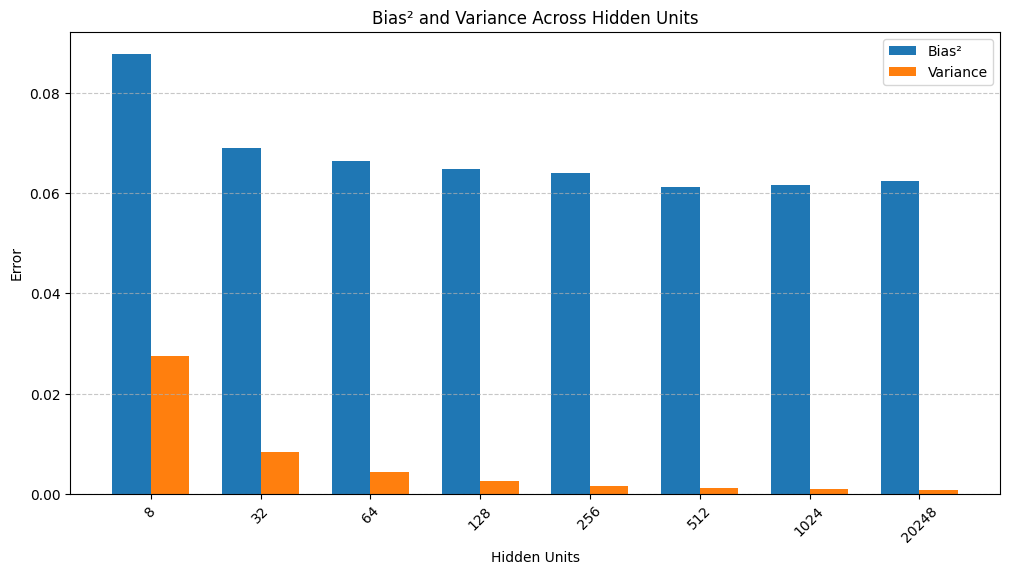

In [30]:
hidden_unit_sizes =[8,32,64,128,256,512,1024,20248]
bias_sq = [r['bias'] for r in results]
variance = [r['variance'] for r in results]


x = np.arange(len(hidden_unit_sizes))  
width = 0.35  
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bias_sq, width, label='Bias²')
plt.bar(x + width/2, variance, width, label='Variance')


plt.xticks(x, hidden_unit_sizes, rotation=45)
plt.xlabel('Hidden Units')
plt.ylabel('Error')
plt.title('Bias² and Variance Across Hidden Units')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

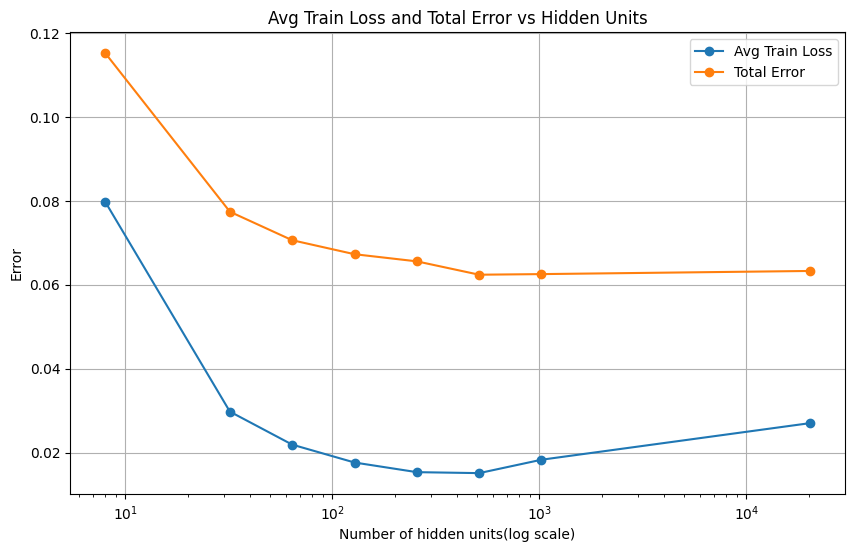

In [33]:
total_error = [r['total_error'] for r in results]
avg_train_loss = [r['avg_train_loss'] for r in results]
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
plt.xscale('log') 
plt.xlabel('Number of hidden units(log scale)')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs Hidden Units')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
bias_values = [res['bias_sq'] for res in results]
variance_values = [res['variance'] for res in results]
error_values = [res['total_error'] for res in results]
bias_plus_variance = [res['error_sum'] for res in results]
    
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, bias_values, marker='o', label='Bias')
plt.plot(hidden_unit_sizes, variance_values, marker='s', label='Variance')
plt.plot(hidden_unit_sizes, error_values, marker='p', label='total error')
# plt.plot(hidden_unit_sizes, bias_plus_variance, marker='p', label='bias + variance')

    
plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for MNIST Regression(Adam optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()

KeyError: 'bias_sq'

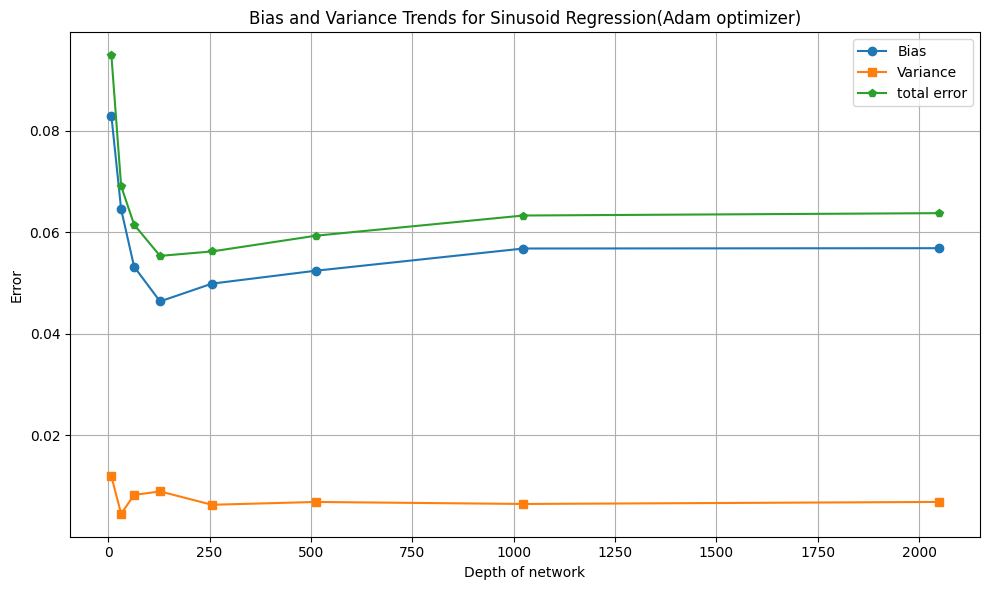

In [18]:
bias_values = [res['bias'] for res in results]
variance_values = [res['variance'] for res in results]
error_values = [res['total_error'] for res in results]
bias_plus_variance = [res['error_sum'] for res in results]
    
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, bias_values, marker='o', label='Bias')
plt.plot(hidden_unit_sizes, variance_values, marker='s', label='Variance')
plt.plot(hidden_unit_sizes, error_values, marker='p', label='total error')
# plt.plot(hidden_unit_sizes, bias_plus_variance, marker='p', label='bias + variance')

    
# plt.xscale('log')
plt.xlabel('Width of the network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(Adam optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()